<p style="font-size:32px; font-weight: bolder; text-align: center"> Path Integral Approximations to Real Time Correlations </p>

<p style="text-align: right">Adapted from i-PI tutorials </p>

<div style="background-color: #e6f7ff ; padding: 15px; border-radius: 10px;">

## Goal   

To use the 3D Morse oscillator as a pedagogical example for exploring how different approximations to real-time quantum correlation functions work.
    
1. Run Classical MD, RPMD, TRPMD, and PA-CMD simulations using the Morse potential with i-PI.  
2. Calculate the spectra from velocity auto time correlation function.
3. Understand limitations of each of the methods.
    
Note: We will run trajectories at 100 K and 32 beads. Reaching convergence for this system requires many more beads at this temperature. These settings are only sufficient for the pedagogical purposes of this exercise. In addition, we will only perform short/few simulations, which also do not represent statistical convergence.

</div>

In [4]:
# Import required libraries

import argparse
import itertools
import sys
import os
import csv
import numpy as np
from matplotlib import pyplot as plt

<div style="background-color: #e6f7ff ; padding: 15px; border-radius: 10px;">

## Morse Potential for OH oscillator

    
$$
V(r) = D\{\exp[-2 a (r-r_0)]- 2 \exp[-a (r-r_0)]\},
$$
where 
1. $D$ is 5.101744 eV 
2. $a$ is 2.1930272 $\mathring{A}$$^{-1}$ 
3. $r_0$ is 0.96966 $\mathring{A}$ 

The fundamental vibrational excitation in this potential lies at $3568$ cm$^{−1}$.

[1]: K. P. Huber and G. Herzberg, Molecular Spectra and Molecular Structure IV. Constants of Diatomic Molecules (Van Nostrand Reinhold, New York, 1979), p. 508.
    
</div>

### Exercise 1: Plot the potential


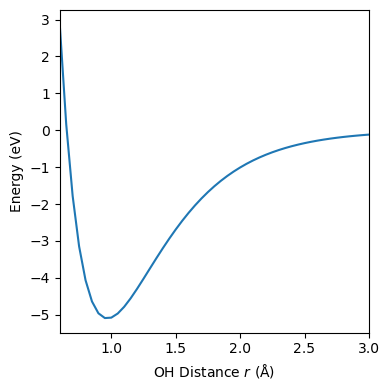

In [5]:
# Equilibrium OH bond length (Å)
r0 = 0.96966

# Morse potential for OH bond
def VmorseOH(r, r0):
    hbar = 6.582119569e-16    # eV·s
    c = 2.99792458e10         # cm/s
    hc = hbar * c * 2 * np.pi # eV·cm
    #mo=15.9994*1836.1527     # atomic units
    #mh=1.00784*1836.1527     # atomic units
    #muoh=mo*mh/(mo+mh)       # atomic units

    we = 3737.76  # Harmonic vibrational frequency (cm⁻¹)
    xe = 84.881   # Anharmonicity constant (cm⁻¹)

    # Morse potential parameters
    D = hc * we**2 / (4 * xe)  # Dissociation energy (eV)
    a = 2.1930272              # Morse parameter (1/Å)

    return D * (np.exp(-2 * a * (r - r0)) - 2 * np.exp(-a * (r - r0)))

# Plotting the potential
r_vals = np.arange(0.6, 5.0, 0.05)
V_vals = [VmorseOH(r, r0) for r in r_vals]

plt.figure(figsize=(4, 4))
plt.plot(r_vals, V_vals)
plt.xlim(0.6, 3.0)
plt.xlabel(r'OH Distance $r$ ($\mathrm{\AA}$)')
plt.ylabel('Energy (eV)')
plt.tight_layout()
plt.show()

<div style="background-color: #e6f7ff ; padding: 15px; border-radius: 10px;">

### 1. Classical spectrum

1. There are several i-PI checkpoints from a classical NVT simulation in the folder `timecorrs/0-classical-therm`. 
2. From these checkpoints, start several classical NVE simulations. Input for the NVE simulations is found in `timecorrs/nve`.
3. When the simulation is complete, build the velocity autocorrelation function and its Fourier transform using the `i-pi-getacf` script.


<div>
<img src="timecorrs/images/fig1.png" width="500"/>
</div>
    
$$
I(\omega) \propto \int e^{i\omega t}\sum_i^{3N} \langle v_i(0) v_i(t) \rangle dt
$$

</div>

<div style="background-color: #e6f7ff ; padding: 15px; border-radius: 10px;">

### 2. RPMD, TRPMD, and CMD spectra

1. There are several i-PI checkpoints from a PIMD simulation in the folder `timecorrs/0-pimd-therm`. 
2. From these checkpoints, start several RPMD/TRPMD/CMD simulations. Input for the RPMD simulations is found in `timecorrs/rmpd` 
3. When the simulation is complete, extract the vibrational spectra from the centroid velocities.

<div>
<img src="timecorrs/images/fig2.png" width="500"/>
</div>

</div>

<div style="background-color: #e6f7ff ; padding: 15px; border-radius: 10px;">

### Example commands:

`$ i-pi rpmd.xml &> log.ipi &` <br>
wait a few seconds <br>
`$ for i in {1..32}; do i-pi-driver -u -a oh-rpmd -m morsedia > out & ; done ` <br>

When the simulation is done, build the centroid velocity autocorrelation function and its Fourier transform. This can be easily achieved with the `i-pi-getacf` script again. The command is: 

`$  i-pi-getacf -ifile simulation.vc.xyz -mlag 1024 -ftpad 3072 -ftwin cosine-hanning -dt "1.0 femtosecond" -oprefix rpmd`

</div>

### Visualization

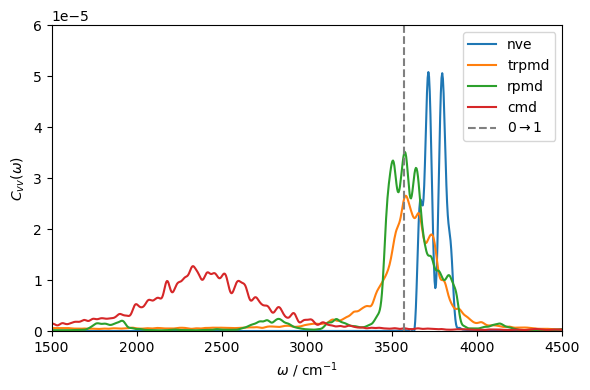

In [3]:
plt.figure(figsize=(6, 4))

# Constants
conv_au_to_cm1 = 219474.63
data_dir = 'timecorrs/precomputed/'
methods = ['nve', 'trpmd', 'rpmd', 'cmd']

# Plot FACF spectra
for method in methods:
    filepath = f'{data_dir}{method}_facf_avg.dat'
    freq, facf = np.loadtxt(filepath, usecols=(0, 1), unpack=True)
    plt.plot(freq * conv_au_to_cm1, facf, label=method)

# Annotations and labels
plt.axvline(x=3568, color='gray', linestyle='--', label=r'$0 \rightarrow 1$')
plt.xlim(1500, 4500)
plt.ylim(0, 6e-5)
plt.xlabel(r'$\omega\ /\ \mathrm{cm}^{-1}$')
plt.ylabel(r'$C_{vv}(\omega)$')
plt.legend()
plt.tight_layout()
plt.show()

## Challenges:

1. How much do the harmonic and anharmonic frequencies of vibration differ?

2. Why is the NVE peak blue-shifted with respect to the true (quantum) fundamental vibrational transition in this potential?

3. Can you spot the spurious resonances of RPMD? 

4. Can you see that the TRPMD spectra do not show the spurious resonances?

5. Can you spot the curvature problem of CMD? Calculate the average OH distances as calculated from the beads and from the centroid. 